In [2]:
!pip install pingouin

   ---------------------------------------- 0.0/198.9 kB ? eta -:--:--
   -- ------------------------------------- 10.2/198.9 kB ? eta -:--:--
   ------------ -------------------------- 61.4/198.9 kB 656.4 kB/s eta 0:00:01
   ---------------------------------------- 198.9/198.9 kB 1.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import bernoulli, cauchy, norm, gamma, poisson, binom, uniform, laplace, expon, trim_mean, iqr, beta, chi2_contingency, kstwobign, kstest, ttest_ind, mannwhitneyu
from scipy.stats import anderson, shapiro, normaltest, weibull_min, anderson_ksamp, permutation_test, ks_2samp, t, kruskal, kendalltau, pearsonr, spearmanr
import scipy.stats as sts
import statistics
from tqdm import tqdm
from matplotlib import rc
from math import pi, log, tan, sin, inf
from scipy.optimize import minimize
from numpy import std
import scipy.special
import statsmodels.api as sm
import pandas as pd
import pingouin as pg
from hyppo.independence import Dcorr


# 1

In [6]:
ex=pd.read_csv('Priem.csv', sep=';', encoding='cp1251')
corr = pd.DataFrame.corr(ex, numeric_only=True )

In [7]:
#display(corr)
corr.iloc[[0,1,2],[0,1,2]]

,Сумма.баллов,ЕГЭ...матем.,ЕГЭ...рус.яз.
Сумма.баллов,1.000000,0.707546,0.375664
ЕГЭ...матем.,0.707546,1.000000,0.152045
ЕГЭ...рус.яз.,0.375664,0.152045,1.000000


In [8]:
pg.pairwise_corr(ex, columns = ['ЕГЭ...матем.', 'ЕГЭ...рус.яз.'	], covar = 'Сумма.баллов')

,X,Y,method,covar,alternative,n,r,CI95%,p-unc
0,ЕГЭ...матем.,ЕГЭ...рус.яз.,pearson,['Сумма.баллов'],two-sided,1385,-0.173364,"[-0.22, -0.12]",8.419600e-11


In [9]:
pg.pairwise_corr(ex, columns = ['ЕГЭ...матем.', 'Сумма.баллов'	], covar = 'ЕГЭ...рус.яз.')

,X,Y,method,covar,alternative,n,r,CI95%,p-unc
0,ЕГЭ...матем.,Сумма.баллов,pearson,['ЕГЭ...рус.яз.'],two-sided,1385,0.710047,"[0.68, 0.74]",9.052377e-213


In [10]:
pg.pairwise_corr(ex, columns = [ 'ЕГЭ...рус.яз.', 'Сумма.баллов'	], covar = 'ЕГЭ...матем.')

,X,Y,method,covar,alternative,n,r,CI95%,p-unc
0,ЕГЭ...рус.яз.,Сумма.баллов,pearson,['ЕГЭ...матем.'],two-sided,1385,0.383418,"[0.34, 0.43]",1.068313e-49


# 2

In [11]:
def chi_chi(pairs, n, m):
    k = int(log(n)/log(2))
    c = int(n/k) #кол-во элементов в промежутке
    t = k-(n - k*c)
    #ищем границы по х
    sorted_datax = np.array([pairs[i][np.argsort(pairs[i][:, 0])] for i in range(m)]) # сортировка выборки по x
    binsx = np.array([[ float(( sorted_datax[j][c*i-1][0]+1e-8)*int(i<=t)+( sorted_datax[j][t*c-1+ (i-t)*(c+1)][0]+1e-8)*int(i>t)) for i in range(1, k)] for j in range(m)])
    binsx = np.concatenate((np.full((m, 1), -np.inf), binsx, np.full((m, 1), np.inf)), axis=1)
    
    sorted_datay = np.array([pairs[i][np.argsort(pairs[i][:, 1])] for i in range(m)]) # сортировка выборки по y
    binsy = np.array([[ float(( sorted_datay[j][c*i-1][1]+1e-8)*int(i<=t)+( sorted_datay[j][t*c-1+ (i-t)*(c+1)][1]+1e-8)*int(i>t)) for i in range(1, k)] for j in range(m)])
    binsy = np.concatenate((np.full((m, 1), -np.inf), binsy, np.full((m, 1), np.inf)), axis=1)
    #дискретизируем
    nu= [np.histogram2d(pairs[i][:,0], pairs[i][:,1], bins=[binsx[i], binsy[i]])[0] for i in range(m)]
    return np.sort(np.array([chi2_contingency(nu[i]).pvalue for i in range(m)]))

In [12]:
def comp(x, y):
    p1 = Dcorr().test(x, y, reps = 2000).pvalue
    p2 = kendalltau(x, y).pvalue
    pairs = np.array([np.column_stack((x, y)) for i in range(1)])
    print(pairs)
    p3 = chi_chi(pairs, len(x), 1)
    print(f'Dcorr p-value = {p1}')
    print(f'Kendall p-value = {p2}')
    print(f'chi2 p-value = {p3[0]}')

In [13]:
def pltpvalue(pairs, n, m, s):
    p1 = np.sort(np.array([Dcorr().test(pairs[i][:, 0], pairs[i][:, 1], reps = 2000).pvalue for i in range(m)]))
    p2 = np.sort(np.array([kendalltau(pairs[i][:, 0], pairs[i][:, 1]).pvalue for i in range(m)]))
    p3 = chi_chi(pairs, n, m)
    R = np.arange(1,m+1)/m
    plt.plot(p1, R, label = 'Dcorr' )
    plt.plot(p2, R, label = 'kendalltau')
    plt.plot(p3, R, label = 'chi')
    plt.plot(R,R, linestyle='dashed', color='gray')
    plt.legend(title = 'tests')
    plt.title(s)

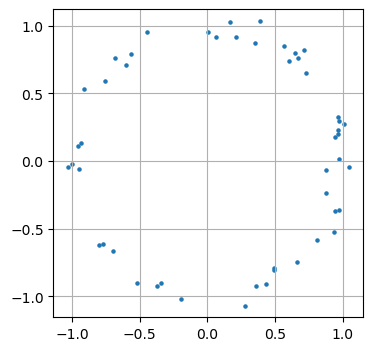

In [14]:
radius_mean = 1
radius_std = 0.05
n = 50
m = 100
radii = np.random.normal(loc=radius_mean, scale=radius_std, size=(m, n))
angles = np.random.uniform(0, 2*np.pi, (m, n))
x = radii * np.cos(angles)
y = radii * np.sin(angles)
pairs = np.array([np.column_stack((x[i], y[i])) for i in range(m)])
plt.figure(figsize=(4, 4))
plt.scatter(x[0], y[0], s=5)
plt.axis('equal')
plt.grid(True)
plt.show()

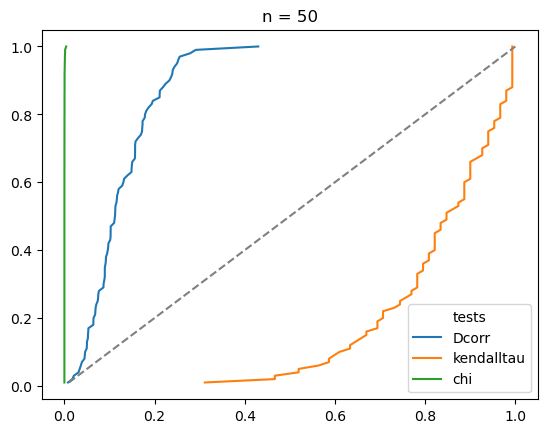

In [15]:
pltpvalue(pairs, n, m, 'n = 50')

C:\Users\User\AppData\Local\Temp\ipykernel_7300\166997032.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  points.append(np.random.multivariate_normal(mean, cov, (m, n)))


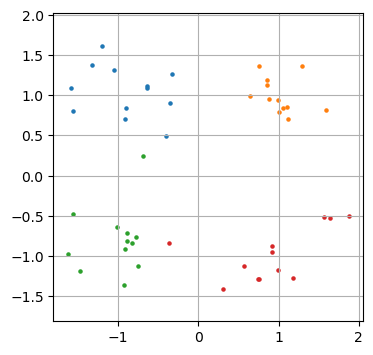

In [16]:
means = [[-1, 1], [1, 1], [-1, -1], [1, -1]]
covs = [[[0.1, 0], [0, 0.1]], [[0.05, 0], [0, 0.05]], [[0.1, 0], [0, 0.2]], [[0.3, 0.1], [0, 0.1]]]
n = 50//4
points = []
m = 100
for mean, cov in zip(means, covs):
    points.append(np.random.multivariate_normal(mean, cov, (m, n)))
plt.figure(figsize=(4, 4))
pairs = np.array([[points[i][j] for i in range(4)] for j in range(m) ])
for cloud in pairs[0]:
    plt.scatter(cloud[:, 0], cloud[:, 1], s=5)
plt.axis('equal')
plt.grid(True)
plt.show()
pairs = [np.concatenate(pairs[i], axis = 0) for i in range(m)]


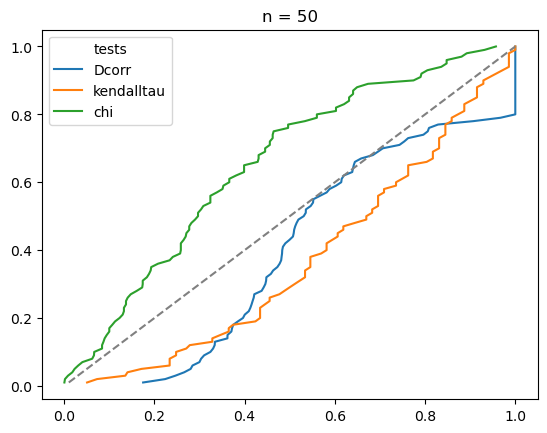

In [17]:
pltpvalue(pairs, 50, m, 'n = 50')

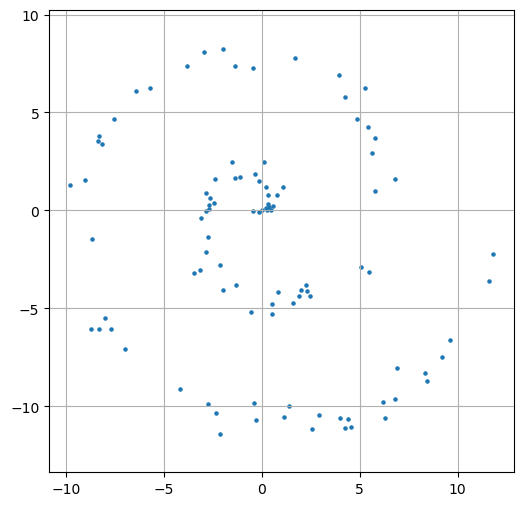

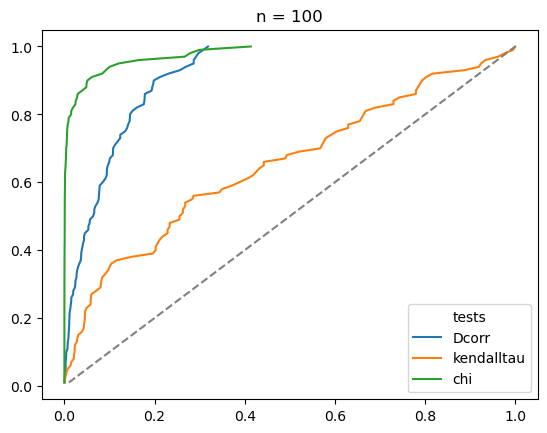

In [18]:
n = 100
m = 100
theta = np.random.uniform(0, 4*np.pi, (m, n))
radius_err =  np.random.normal(loc=0, scale=0.5, size=(m, n))
radius = theta + radius_err
x = radius * np.cos(theta)
y = radius * np.sin(theta)
plt.figure(figsize=(6, 6))
plt.scatter(x[0], y[0], s=5)
plt.axis('equal')
plt.grid(True)
plt.show()
pairs = np.array([np.column_stack((x[i], y[i])) for i in range(m)])
pltpvalue(pairs, n, m, 'n = 100')

# 3

In [19]:
n, m = 4000, 2000
u1 = uniform.rvs(size = (m,n))
u2 = uniform.rvs(size = (m,n))

# H[i][j] = H(x_j, y_j) - эфр для i-выборки пар
# G[i][j] =G(x_j)  эфр для i-выборки для х
# F - для у

H =  [[np.mean(np.logical_and(u1[i]<=u1[i][j], u2[i]<=u2[i][j])) for j in range(n)] for i in tqdm(range(m))] # смирнов
G = [[np.mean(u1[i]<=u1[i][j]) for j in range(n)] for i in tqdm(range(m))]
F = [[np.mean(u2[i]<=u2[i][j]) for j in range(n)] for i in range(m)]
T = np.array([np.max(np.array([max(abs(H[i][j] - G[i][j]*F[i][j]), abs(H[i][j]-1/n - (G[i][j]-1/n)*F[i][j]), abs(H[i][j]-1/n - G[i][j]*(F[i][j]-1/n)), abs(H[i][j]-1/n - (G[i][j]-1/n)*(F[i][j]-1/n))) for j in range(n)])) for i in tqdm(range(m))])*(n**0.5)
with open('Smirnov_ind.txt', 'w') as f:
    f.writelines(f"{item}\n" for item in T)

100%|██████████| 2000/2000 [00:25<00:00, 77.68it/s]


In [20]:
with open('Smirnov_ind.txt', 'r') as file:
    lines = file.read().splitlines()
lines = list(map(float, lines))
f = ECDF(lines)

In [21]:
def Smirnov_pv(u1, u2, n, m):
    H =  [[np.mean(np.logical_and(u1[i]<=u1[i][j], u2[i]<=u2[i][j])) for j in range(n)] for i in range(m)]
    G = [[np.mean(u1[i]<=u1[i][j]) for j in range(n)] for i in range(m)]
    F = [[np.mean(u2[i]<=u2[i][j]) for j in range(n)] for i in range(m)]
    T = np.array([np.max(np.array([max(abs(H[i][j] - G[i][j]*F[i][j]), abs(H[i][j]-1/n - (G[i][j]-1/n)*F[i][j]), abs(H[i][j]-1/n - G[i][j]*(F[i][j]-1/n)), abs(H[i][j]-1/n - (G[i][j]-1/n)*(F[i][j]-1/n))) for j in range(n)])) for i in range(m)])*(n**0.5)
    return np.sort(1 - f(T))

In [22]:
def tests(x, y, n, m, s):
    p_sm = Smirnov_pv(x, y, n, m)
    p_pear = np.sort([pearsonr(x[i], y[i]).pvalue for i in range(m)])
    p_ken = np.sort([kendalltau(x[i], y[i]).pvalue for i in range(m)])
    p_spir = np.sort([spearmanr(x[i], y[i]).pvalue for i in range(m)])
    p_sr = np.sort([Dcorr().test(x[i], y[i]).pvalue for i in range(m)])
    R = np.arange(1,m+1)/m
    plt.plot(p_sm, R, label = 'Smirnov' )
    plt.plot(p_pear, R, label = 'Pearson')
    plt.plot(p_ken, R, label = 'Kendall')
    plt.plot(p_spir, R, label = 'Spirmen')
    plt.plot(p_sr, R, label = 'Dcorr')
    plt.plot(R,R, linestyle='dashed', color='gray')
    plt.legend(title = 'tests')
    plt.title(s)

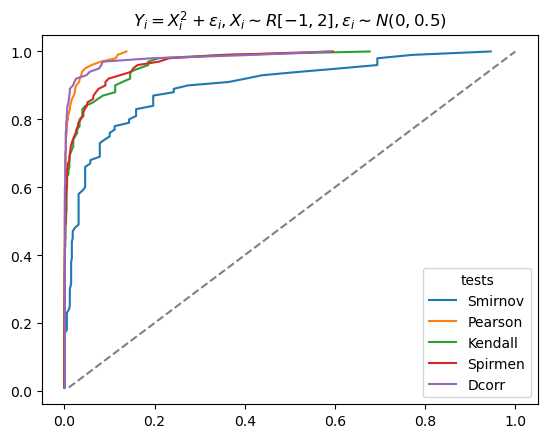

In [23]:
n, m = 20, 100
x = uniform.rvs(loc =-1, scale = 3, size = (m,n))
eps = norm.rvs(scale = 0.5**0.5, size = (m, n))
y = x**2+eps
tests(x, y, n, m, r'$ Y_i = X_i^2 + \varepsilon_i, X_i \sim R[-1, 2], \varepsilon_i \sim N(0, 0.5) $')

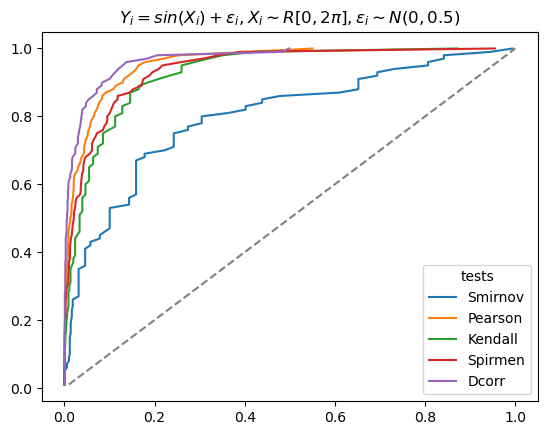

In [24]:
n, m = 20, 100
x = uniform.rvs(loc =0, scale = 2*pi, size = (m,n))
eps = norm.rvs(scale = 0.5**0.5, size = (m, n))
y = np.sin(x)+eps
tests(x, y, n, m, r'$ Y_i = sin (X_i) + \varepsilon_i, X_i \sim R[0, 2\pi], \varepsilon_i \sim N(0, 0.5) $')